# Deteksi Pneumonia



Layanan kesehatan / kesehatan adalah bagian penting dari revolusi teknologi, dengan banyaknya teknik deep learning yang diaplikasikan pada banyak masalah-masalah medis saat ini. 

Data yang digunakan adalah citra x-ray yang akan dimasukkan ke dalam model untuk menentukan apakah seseorang mengidap pneumonia ataukah tidak. Model ini merupakan model klasifikasi binari, yang akan menghasilkan dua hasil prediksi, ya ataukah tidak (0 atau 1).

Notebook ini dibuat menggunakan paltform google colab, dan menggunakan transfer learning dari arsitektur ResNet50. Setelah training selama dan sepanjang 10 epochs, dicapai akurasi sebesar lebih dari 80%. Modifikasi kecil dan perubahan/penambahan komponen arsitektur tentu saja dapat meningkatkan akurasi hingga mencapai 90% atau bahkan lebih dari itu.

Dengan menuliskan kode sederhana di bawah ini, kita dapat menggunakan API Kaggle untuk mengunduh data ke dalam notebook kita. 

In [15]:
import os
os.environ['KAGGLE_USERNAME'] = "dzelrahman"
os.environ['KAGGLE_KEY'] = "22981b181745de2419d1ae63d77468e8"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


Kemudian, file yang sudah diunduh harus diunzip terlebih dahulu karena file masih berupa format zip, dan pula ditentukan direktori khusus untuk set train, test, dan validation. Ditentukan pula direktori untuk dua kelas, normal dan pneumonia untuk masing-masing data train dan validation.

In [16]:
import zipfile
local_zip = "/content/chest-xray-pneumonia.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [17]:
base_dir = '/content/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [18]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneu_dir = os.path.join(validation_dir, 'PNEUMONIA')

In [19]:
print(len(os.listdir(train_normal_dir)))
print(len(os.listdir(train_pneu_dir)))

1341
3875


Ada sebanyak 1341 citra X-ray yang tergolong berparu-paru normal dan ada 3875 citra x-ray yang tergolong mengidap pneumonia, dimana jumlah gambar ini sudah mencukupi.

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [21]:
img_size=[224,224]
model=tf.keras.applications.resnet50.ResNet50(input_shape=img_size + [3], weights='imagenet', include_top=False)
model.trainable = False

Lapisan akhir dari arsitektur adalah 'conv5_block3_out' dengan bentuk/shape sebesar (7,7,2048) yang akan digunakan kemudian.

In [22]:
last_layer = model.get_layer("conv5_block3_out")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


Kita kemudian menentukan 2 lapisan terakhir, lapisan dense dengan 1024 jumlah nodes, dengan rasio dropout sebesar 20% untuk menanggulangi overfitting. Lapisan berikutnya adalah lapisan terakhir dengan node tunggal dan ditambah dengan aktivasi sigmoid (yang menghasilkan keluaran berupa 0 dan 1 untuk klasifikasi).

In [23]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation='sigmoid')(x)

In [24]:
amodel = Model(model.input,x)

Lapisan yang terdapat pada model kita, bernama amodel, dan bentuk beserta ukurannya dapat dilihat menggunakan fungsi summary().

In [25]:
amodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Setelah melakukan fit terhadap model, model dicompile menggunakan RMSProp sebagai optimizer dan juga binary_crossentropy sebagai loss karena hasil akan berupa salah satu dari dua kelas prediksi.

In [26]:
from tensorflow.keras.optimizers import RMSprop
amodel.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Selanjutnya, kita menggunakan fungsi ImageDataGenerator pada Keras untuk memasukkan/mengimport gambar dan melakukan beberapa data augmentasi terhadap gambar tersebut, dan juga menuliskan beberapa argumen.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=20,
                                                   class_mode = 'binary',
                                                   target_size = (224,224))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size = 20,
                                                       class_mode = 'binary',
                                                       target_size = (224,224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Ada 5216 gambar untuk training dan 16 gambar untuk validation. Langkah terakhir yang dilakukan adalah melakukan running terhadap model sebanyak 10 epochs. 

In [28]:
history = amodel.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 10,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/10
100/100 - 40s - loss: 0.8766 - accuracy: 0.6995 - val_loss: 0.6713 - val_accuracy: 0.5625
Epoch 2/10
100/100 - 39s - loss: 0.5579 - accuracy: 0.7340 - val_loss: 0.6691 - val_accuracy: 0.5625
Epoch 3/10
100/100 - 39s - loss: 0.5284 - accuracy: 0.7365 - val_loss: 1.1267 - val_accuracy: 0.5000
Epoch 4/10
100/100 - 39s - loss: 0.4807 - accuracy: 0.7685 - val_loss: 0.9095 - val_accuracy: 0.5625
Epoch 5/10
100/100 - 39s - loss: 0.4465 - accuracy: 0.7886 - val_loss: 1.0115 - val_accuracy: 0.5625
Epoch 6/10
100/100 - 40s - loss: 0.4675 - accuracy: 0.7705 - val_loss: 0.8168 - val_accuracy: 0.5625
Epoch 7/10
100/100 - 39s - loss: 0.4453 - accuracy: 0.7830 - val_loss: 0.8150 - val_accuracy: 0.6250
Epoch 8/10
100/100 - 39s - loss: 0.4186 - accuracy: 0.7915 - val_loss: 0.5470 - val_accuracy: 0.6875
Epoch 9/10
100/100 - 39s - loss: 0.4212 - accuracy: 0.7955 - val_loss: 0.8042 - val_accuracy: 0.6250
Epoch 10/10
100/100 - 39s - loss: 0.3977 - accuracy: 0.8105 - val_loss: 0.5555 - val_accura

Kita berhasil mendapatkan sekitar 81% akurasi setelah 10 epochs. Akurasi validasi adalah sekitar 62%. Arsitektur lain seperti VGG16 atau VGG19 dapat pula digunakan dan dapat meningkatkan akurasi.

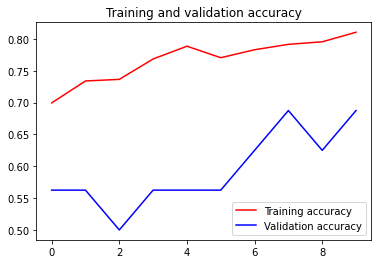

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

Akurasi training nampak meningkat secara konsisten, namun akurasi validasi nampak naik dan turun, meskipun secara umum meningkat. Ini bisa jadi merupakan salah satu tanda terjadinya overfit, namun bukan overfit yang parah.